In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
from google.colab import files

# Upload the kaggle.json file
uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!pip install kaggle

!kaggle datasets download -d msambare/fer2013

!unzip fer2013.zip


In [ ]:
train_dir = 'train/'
test_dir = 'test/'

def Classes_Count( path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):

        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])

    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)



In [ ]:
pd.concat([Train_Count,Test_Count] , axis=1)


,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<Axes: >

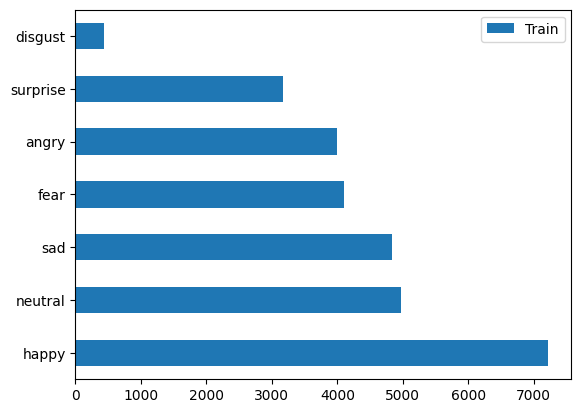

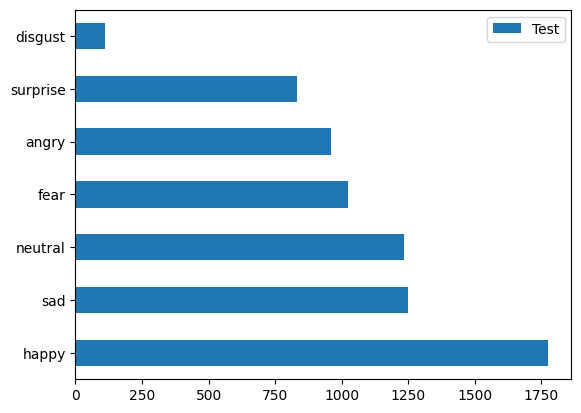

In [ ]:

Train_Count.plot(kind='barh')
Test_Count.plot(kind='barh')


### In our data disgust is significantly lower than the rest. this might cause some accuracy issues later.


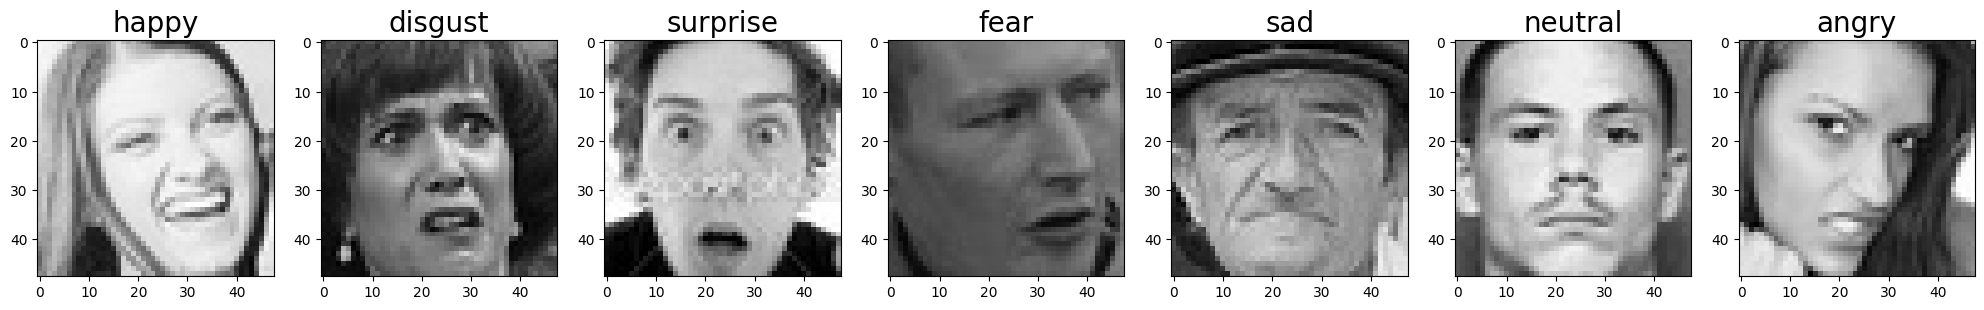

In [ ]:
import os
import matplotlib.pyplot as plt
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = 'train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()


model.add(Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))

#Output
model.add(Flatten())


model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7,activation='softmax'))
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 conv2d_28 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 23, 23, 64)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 23, 23, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 12, 12, 128)      0         
 g2D)                                                 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator with automatic conversion to RGB and augmentation options
datagen = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )

# Generate augmented training data
augmented_train_data = datagen.flow_from_directory(
    directory='train',
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',  # Use 'sparse' for integer labels
    batch_size=32,
    shuffle=True,
    subset='training'
)

# Define the test generator
test_generator = datagen.flow_from_directory(
    directory='test',
    target_size=(48, 48),
    color_mode='grayscale',   # Automatically convert grayscale to RGB
    class_mode='categorical',  # Use 'sparse' for integer labels
    batch_size=32,
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

Checkpoint = ModelCheckpoint("CNN_Model_Checkpoint", monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3,min_lr=0.000005,verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = augmented_train_data.n // augmented_train_data.batch_size
validation_steps = test_generator.n // test_generator.batch_size
CNN_history = model.fit( augmented_train_data , validation_data= augmented_train_data , epochs=100, batch_size= 32,
                            callbacks=callbacks, steps_per_epoch= steps_per_epoch, validation_steps=validation_steps)


Epoch 1/100
897/897 [==============================] - 33s 33ms/step - loss: 1.8522 - accuracy: 0.2602 - val_loss: 1.7499 - val_accuracy: 0.3005 - lr: 0.0010
Epoch 2/100
897/897 [==============================] - 29s 32ms/step - loss: 1.6928 - accuracy: 0.3257 - val_loss: 1.5562 - val_accuracy: 0.4056 - lr: 0.0010
Epoch 3/100
897/897 [==============================] - 28s 31ms/step - loss: 1.5311 - accuracy: 0.4045 - val_loss: 1.3867 - val_accuracy: 0.4713 - lr: 0.0010
Epoch 4/100
897/897 [==============================] - 29s 32ms/step - loss: 1.4151 - accuracy: 0.4565 - val_loss: 1.3259 - val_accuracy: 0.4837 - lr: 0.0010
Epoch 5/100
897/897 [==============================] - 29s 32ms/step - loss: 1.3629 - accuracy: 0.4822 - val_loss: 1.2758 - val_accuracy: 0.5153 - lr: 0.0010
Epoch 6/100
897/897 [==============================] - 28s 31ms/step - loss: 1.3211 - accuracy: 0.4964 - val_loss: 1.2372 - val_accuracy: 0.5278 - lr: 0.0010
Epoch 7/100
897/897 [==============================]

In [ ]:
model.save("firstmodel.h5")

In [ ]:
from google.colab import files
files.download('firstmodel.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

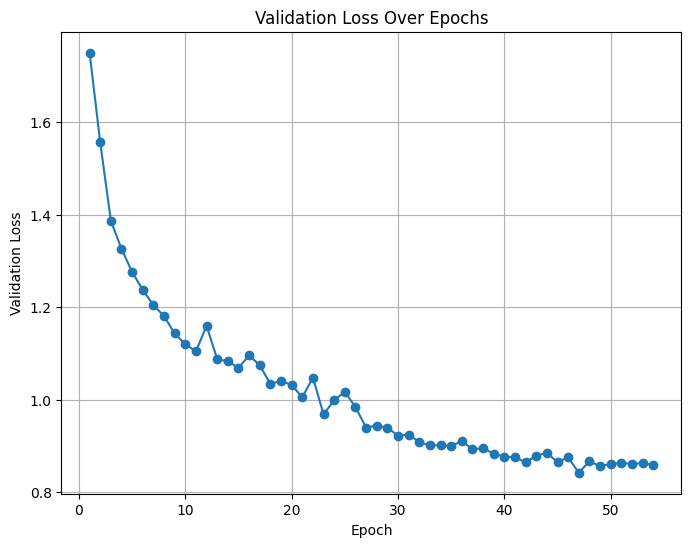

In [ ]:
import matplotlib.pyplot as plt

# Provided validation losses
validation_losses = [
    1.7499, 1.5562, 1.3867, 1.3259, 1.2758, 1.2372, 1.2044, 1.1805, 1.1430, 1.1198,
    1.1041, 1.1595, 1.0876, 1.0827, 1.0687, 1.0954, 1.0744, 1.0335, 1.0406, 1.0316,
    1.0049, 1.0475, 0.9680, 0.9986, 1.0169, 0.9839, 0.9395, 0.9437, 0.9395, 0.9220,
    0.9242, 0.9084, 0.9008, 0.9018, 0.8990, 0.9105, 0.8926, 0.8949, 0.8829, 0.8765,
    0.8756, 0.8644, 0.8788, 0.8845, 0.8651, 0.8750, 0.8419, 0.8664, 0.8562, 0.8604,
    0.8631, 0.8612, 0.8623, 0.8589
]

# Create an array to store all validation losses
all_val_losses = []

# Add each provided validation loss to the array
for epoch_val_loss in validation_losses:
    all_val_losses.append(epoch_val_loss)

# Plot the validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.grid(True)
plt.show()


### **The graph shows the validation loss over epochs during model training. Initially, the loss decreases rapidly as the model learns. It then stabilizes, indicating convergence. The best validation loss on the graph is achieved around epoch 49, where the validation loss curve reaches its lowest point. After this epoch, the validation loss starts to increase slightly.**